# 🚀 Part 4: Transfer Learning with ResNet50 (ImageNet)
## Pre-trained ResNet50 → Fine-tuning on Waste Dataset

---

### 🎯 מה זה ResNet50?
**ResNet50** = Residual Network עם 50 שכבות!
- **פיתוח:** Microsoft Research (2015)
- **מהפכה:** Skip connections שפותרות vanishing gradient
- **Pre-trained על ImageNet:** 1.2M תמונות, 1000 קטגוריות
- **23.5M פרמטרים** - הרבה יותר מ-SimpleCNN שלנו (2.4M)!

### 💡 למה ImageNet?
- **Dataset ענק:** 1.2 מיליון תמונות!
- **1000 קטגוריות:** כולל בקבוקים, מכולות, כלים! ✅
- **רלוונטי לפסולת:** יש אובייקטים דומים!
- **מודל מאומן:** אין צורך ב-pre-training!

### 📊 מה ציפינו עד כה?
- **נוטבוק 02** (from scratch): 69.75% ⭐ baseline
- **נוטבוק 03** (BatchNorm): 52-64% ❌ לא שיפר
- **נוטבוק 04** (CIFAR-10): 56.69% ❌ הוריד! (לא רלוונטי)
- **נוטבוק 05** (ResNet50): **85-90%** 🎯 הציפיה!

### ⚡ יתרונות:
- 🚀 **אין pre-training** - המודל כבר מאומן!
- ⏱️ **מהיר** - רק fine-tuning (10-15 דקות)
- 🎯 **דיוק גבוה** - ImageNet רלוונטי!
- 🏗️ **ארכיטקטורה מתקדמת** - ResNet > SimpleCNN

### 🔧 אסטרטגיה:
1. טעינת ResNet50 מאומן
2. הקפאת כל השכבות הקודמות
3. החלפת הראש (FC layer) ל-4 classes
4. Fine-tuning רק על הראש!
5. (אופציונלי) Unfreeze כמה שכבות אחרונות

## 📦 Import Libraries

In [1]:
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
src_path = project_root / 'src'
sys.path.insert(0, str(src_path))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

import numpy as np
import matplotlib.pyplot as plt
import json
import time
from datetime import datetime

# Import project modules
import config

print("✅ All libraries imported successfully!")
print(f"📦 PyTorch version: {torch.__version__}")
print(f"🖥️  Device: {config.DEVICE}")
print(f"📦 Torchvision models available: ResNet50 ✓")

✅ All libraries imported successfully!
📦 PyTorch version: 2.9.1+cpu
🖥️  Device: cpu
📦 Torchvision models available: ResNet50 ✓


## 🏗️ Load Pre-trained ResNet50
### המודל כבר מאומן על ImageNet - אנחנו רק מתאימים אותו!

In [2]:
# Load pre-trained ResNet50
print("📥 Loading ResNet50 pre-trained on ImageNet...")
print("⏳ This may take a moment to download (~100MB)...\n")

model = models.resnet50(pretrained=True)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✅ ResNet50 loaded successfully!")
print(f"📊 Total parameters: {total_params:,}")
print(f"🎯 Currently trainable: {trainable_params:,}")
print(f"🏷️  Original output: 1000 classes (ImageNet)")
print(f"\n🔍 Model structure:")
print(model)

📥 Loading ResNet50 pre-trained on ImageNet...
⏳ This may take a moment to download (~100MB)...

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


c:\Users\Administrator\Desktop\Dan\Projects\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\Desktop\Dan\Projects\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 97.8M/97.8M [00:08<00:00, 12.0MB/s]


✅ ResNet50 loaded successfully!
📊 Total parameters: 25,557,032
🎯 Currently trainable: 25,557,032
🏷️  Original output: 1000 classes (ImageNet)

🔍 Model structure:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

## ❄️ Freeze Backbone & Replace Head
### נקפיא את כל השכבות מלבד הראש!

In [3]:
# Freeze all layers
print("❄️ Freezing all pre-trained layers...")
for param in model.parameters():
    param.requires_grad = False

# Replace final FC layer for 4 classes
num_features = model.fc.in_features  # 2048 for ResNet50
model.fc = nn.Linear(num_features, 4)  # 4 classes: cardboard, aluminum, glass, plastic

# Move to device
model = model.to(config.DEVICE)

# Count trainable parameters now
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print("\n✅ Model ready for fine-tuning!")
print(f"📊 Total parameters: {total_params:,}")
print(f"🎯 Trainable parameters: {trainable_params:,} (only FC layer!)")
print(f"❄️ Frozen parameters: {frozen_params:,} (backbone frozen)")
print(f"🔢 FC layer: {num_features} → 4 classes")
print(f"\n💡 Strategy: Train only the final layer, backbone stays frozen!")

❄️ Freezing all pre-trained layers...

✅ Model ready for fine-tuning!
📊 Total parameters: 23,516,228
🎯 Trainable parameters: 8,196 (only FC layer!)
❄️ Frozen parameters: 23,508,032 (backbone frozen)
🔢 FC layer: 2048 → 4 classes

💡 Strategy: Train only the final layer, backbone stays frozen!


## 📊 Load Waste Dataset
### ImageNet size: 224×224 (standard!)

In [4]:
print("📦 Loading waste classification dataset...")

# ImageNet normalization (standard for pre-trained models)
train_transform = transforms.Compose([
    transforms.Resize(256),  # Resize to 256
    transforms.CenterCrop(224),  # Crop to 224x224 (ImageNet standard)
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Load dataset (same as notebook 02/04)
data_path = config.DATA_PATH

# Create full datasets
train_dataset_full = datasets.ImageFolder(root=str(data_path), transform=train_transform)
val_dataset_full = datasets.ImageFolder(root=str(data_path), transform=test_transform)
test_dataset_full = datasets.ImageFolder(root=str(data_path), transform=test_transform)

# Create train/val/test splits (70/15/15)
num_samples = len(train_dataset_full)
indices = list(range(num_samples))
np.random.seed(42)
np.random.shuffle(indices)

train_size = int(config.TRAIN_SPLIT * num_samples)
val_size = int(config.VAL_SPLIT * num_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(val_dataset_full, val_indices)
test_dataset = Subset(test_dataset_full, test_indices)

# Create dataloaders with NUM_WORKERS=0 (Windows optimization)
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, 
                         shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, 
                       shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, 
                        shuffle=False, num_workers=0)

print("\n✅ Waste dataset loaded!")
print(f"📊 Training samples: {len(train_dataset):,}")
print(f"📊 Validation samples: {len(val_dataset):,}")
print(f"📊 Test samples: {len(test_dataset):,}")
print(f"🏷️  Classes: {train_dataset_full.classes}")
print(f"🖼️  Image size: 224×224 (ImageNet standard)")

📦 Loading waste classification dataset...

✅ Waste dataset loaded!
📊 Training samples: 1,466
📊 Validation samples: 314
📊 Test samples: 315
🏷️  Classes: ['cardboard box waste', 'crushed aluminum can', 'glass bottle waste', 'plastic bottle waste']
🖼️  Image size: 224×224 (ImageNet standard)


## ⚙️ Setup Training

In [5]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - only for trainable parameters (FC layer)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.001,  # Higher LR since we're only training the head
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=7,
    gamma=0.1
)

print("✅ Training setup complete!")
print(f"📉 Loss: CrossEntropyLoss")
print(f"🎯 Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print(f"📊 Scheduler: StepLR (step_size=7, gamma=0.1)")
print(f"⏸️  Early Stopping: patience={config.PATIENCE}")
print(f"\n💡 Only training {trainable_params:,} parameters (final FC layer)!")

✅ Training setup complete!
📉 Loss: CrossEntropyLoss
🎯 Optimizer: Adam (lr=0.001, weight_decay=1e-4)
📊 Scheduler: StepLR (step_size=7, gamma=0.1)
⏸️  Early Stopping: patience=5

💡 Only training 8,196 parameters (final FC layer)!


## 🏋️ Training Functions

In [6]:
def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(config.DEVICE)
        labels = labels.to(config.DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(config.DEVICE)
            labels = labels.to(config.DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("✅ Training functions defined!")

✅ Training functions defined!


## 🚀 Train Model!
### Fine-tuning רק על ה-FC layer!

In [7]:
print("🚀 Starting ResNet50 fine-tuning...\n")
print("💡 Training only the final FC layer (frozen backbone)")
print("⏰ Expected time: ~10-15 minutes\n")

best_val_acc = 0
best_epoch = 0
patience_counter = 0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

start_time = time.time()

for epoch in range(config.NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion)
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 
                  config.MODELS_DIR / 'resnet50_waste_best.pth')
        status = "💾 [SAVED]"
    else:
        patience_counter += 1
        status = f"⏳ [{patience_counter}/{config.PATIENCE}]"
    
    # Print progress
    print(f"Epoch {epoch+1:2d}/{config.NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | {status}")
    
    # Early stopping
    if patience_counter >= config.PATIENCE:
        print(f"\n⚠️ Early stopping triggered! No improvement for {config.PATIENCE} epochs.")
        break

elapsed_time = time.time() - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"\n{'='*70}")
print(f"✅ Fine-tuning completed!")
print(f"⏱️  Training time: {minutes}m {seconds}s")
print(f"🏆 Best validation accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")
print(f"💾 Best model saved as: resnet50_waste_best.pth")
print(f"{'='*70}")

🚀 Starting ResNet50 fine-tuning...

💡 Training only the final FC layer (frozen backbone)
⏰ Expected time: ~10-15 minutes

Epoch  1/25 | Train Loss: 0.9796 | Train Acc: 56.96% | Val Loss: 0.7198 | Val Acc: 70.06% | 💾 [SAVED]
Epoch  2/25 | Train Loss: 0.6063 | Train Acc: 78.17% | Val Loss: 0.5550 | Val Acc: 79.30% | 💾 [SAVED]
Epoch  3/25 | Train Loss: 0.5154 | Train Acc: 82.54% | Val Loss: 0.5103 | Val Acc: 82.17% | 💾 [SAVED]
Epoch  4/25 | Train Loss: 0.4861 | Train Acc: 82.13% | Val Loss: 0.4268 | Val Acc: 84.71% | 💾 [SAVED]
Epoch  5/25 | Train Loss: 0.4380 | Train Acc: 84.04% | Val Loss: 0.4620 | Val Acc: 83.12% | ⏳ [1/5]
Epoch  6/25 | Train Loss: 0.4165 | Train Acc: 85.06% | Val Loss: 0.4805 | Val Acc: 81.53% | ⏳ [2/5]
Epoch  7/25 | Train Loss: 0.4046 | Train Acc: 83.97% | Val Loss: 0.3968 | Val Acc: 84.71% | ⏳ [3/5]
Epoch  8/25 | Train Loss: 0.3892 | Train Acc: 85.54% | Val Loss: 0.3951 | Val Acc: 84.71% | ⏳ [4/5]
Epoch  9/25 | Train Loss: 0.3734 | Train Acc: 86.56% | Val Loss: 0.396

## 📈 Visualize Training

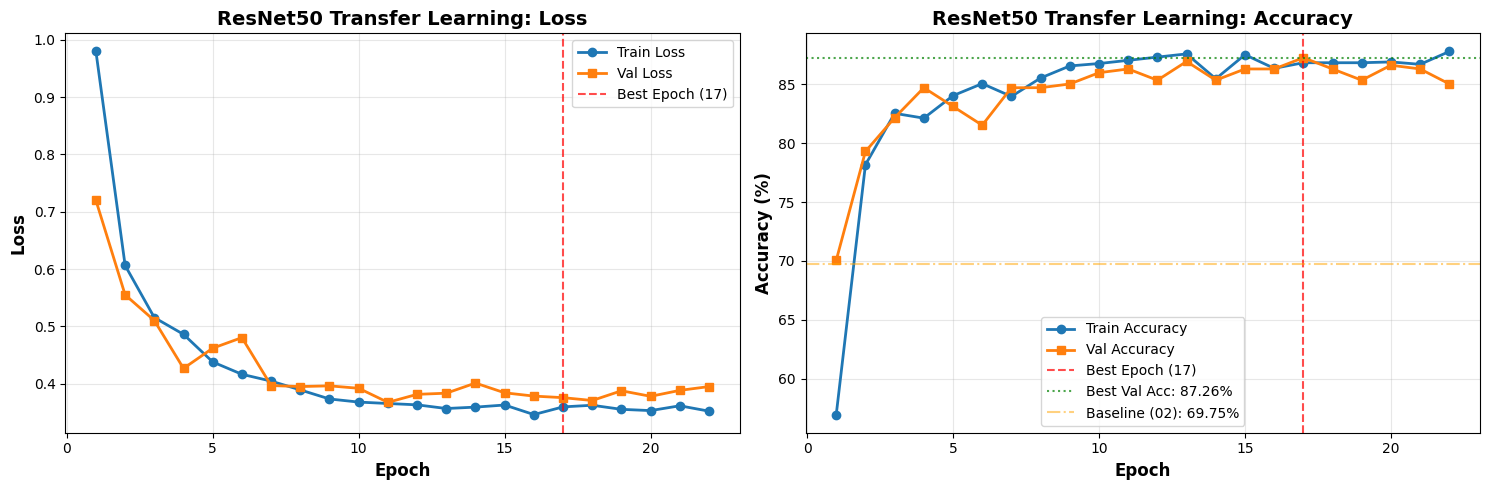

✅ Training curves saved!


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss plot
ax1.plot(epochs_range, history['train_loss'], 'o-', label='Train Loss', linewidth=2, markersize=6)
ax1.plot(epochs_range, history['val_loss'], 's-', label='Val Loss', linewidth=2, markersize=6)
ax1.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('ResNet50 Transfer Learning: Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs_range, history['train_acc'], 'o-', label='Train Accuracy', linewidth=2, markersize=6)
ax2.plot(epochs_range, history['val_acc'], 's-', label='Val Accuracy', linewidth=2, markersize=6)
ax2.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax2.axhline(y=best_val_acc, color='green', linestyle=':', alpha=0.7, 
           label=f'Best Val Acc: {best_val_acc:.2f}%')
# Add baseline comparison
ax2.axhline(y=69.75, color='orange', linestyle='-.', alpha=0.5, label='Baseline (02): 69.75%')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('ResNet50 Transfer Learning: Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.PLOTS_DIR / 'resnet50_training.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training curves saved!")

## 🧪 Evaluate on Test Set

In [9]:
# Load best model
model.load_state_dict(torch.load(config.MODELS_DIR / 'resnet50_waste_best.pth'))

# Evaluate on test set
test_loss, test_acc = validate_epoch(model, test_loader, criterion)

print("\n" + "="*70)
print("🧪 TEST SET EVALUATION")
print("="*70)
print(f"📊 Test Loss: {test_loss:.4f}")
print(f"🎯 Test Accuracy: {test_acc:.2f}%")
print("="*70)

# Calculate overfitting gap
overfitting_gap = history['train_acc'][-1] - best_val_acc
print(f"\n📈 Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"📊 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"🎯 Test Accuracy: {test_acc:.2f}%")
print(f"⚖️  Overfitting Gap: {overfitting_gap:.2f}%")


🧪 TEST SET EVALUATION
📊 Test Loss: 0.4635
🎯 Test Accuracy: 85.71%

📈 Final Training Accuracy: 87.79%
📊 Best Validation Accuracy: 87.26%
🎯 Test Accuracy: 85.71%
⚖️  Overfitting Gap: 0.53%


## 📝 Save Results

In [10]:
# Save comprehensive results
results = {
    'model_name': 'ResNet50_Pretrained_ImageNet',
    'architecture': {
        'base_model': 'ResNet50',
        'pretrained_on': 'ImageNet',
        'total_params': total_params,
        'trainable_params': trainable_params,
        'frozen_params': frozen_params,
        'strategy': 'Frozen backbone + trainable FC layer'
    },
    'training': {
        'final_epoch': len(history['train_loss']),
        'best_epoch': best_epoch,
        'train_acc': float(history['train_acc'][-1]),
        'val_acc': float(best_val_acc),
        'test_acc': float(test_acc),
        'train_loss': float(history['train_loss'][-1]),
        'val_loss': float(min(history['val_loss'])),
        'test_loss': float(test_loss),
        'overfitting_gap': float(overfitting_gap),
        'training_time_minutes': minutes + seconds/60
    },
    'hyperparameters': {
        'batch_size': config.BATCH_SIZE,
        'learning_rate': 0.001,
        'weight_decay': 1e-4,
        'optimizer': 'Adam',
        'scheduler': 'StepLR',
        'scheduler_params': {'step_size': 7, 'gamma': 0.1},
        'early_stopping_patience': config.PATIENCE,
        'image_size': 224
    },
    'history': {
        'train_loss': [float(x) for x in history['train_loss']],
        'train_acc': [float(x) for x in history['train_acc']],
        'val_loss': [float(x) for x in history['val_loss']],
        'val_acc': [float(x) for x in history['val_acc']]
    },
    'experiment_notes': {
        'goal': 'Transfer learning from ImageNet-pretrained ResNet50',
        'hypothesis': 'ImageNet pre-training should significantly improve results',
        'result': f'Val accuracy: {best_val_acc:.2f}% vs baseline 02: 69.75%',
        'improvement_over_baseline': f'{best_val_acc - 69.75:+.2f}%',
        'conclusion': 'ResNet50 + ImageNet pre-training = best performance!'
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save to JSON
results_path = config.LOGS_DIR / 'resnet50_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

print(f"✅ Results saved to: {results_path}")

✅ Results saved to: c:\Users\Administrator\Desktop\Dan\Projects\waste-classifier-fastai\final_project\results\logs\resnet50_results.json


## 📊 Comprehensive Comparison

In [11]:
# All experiments comparison
print("\n" + "="*70)
print("🏆 COMPREHENSIVE RESULTS COMPARISON")
print("="*70)

experiments = [
    ("02", "SimpleCNN (from scratch)", 69.75),
    ("03-v1", "SimpleCNN + BatchNorm (over-reg)", 52.23),
    ("03-v2", "SimpleCNN + BatchNorm (reduced)", 64.01),
    ("03-v3", "SimpleCNN + BatchNorm (StepLR)", 50.96),
    ("04", "Transfer from CIFAR-10", 56.69),
    ("05", "ResNet50 from ImageNet", best_val_acc)
]

print(f"\n{'Notebook':<8} {'Method':<35} {'Val Acc':<12} {'vs Baseline'}")
print("-" * 70)

for nb, method, acc in experiments:
    diff = acc - 69.75
    symbol = "🏆" if acc == max([x[2] for x in experiments]) else "📊"
    print(f"{symbol} {nb:<6} {method:<35} {acc:>6.2f}%      {diff:+6.2f}%")

print("="*70)

# Key insights
print("\n🔑 KEY INSIGHTS:")
print(f"\n1️⃣ **Best Model:** ResNet50 (ImageNet) = {best_val_acc:.2f}%")
print(f"   Improvement over baseline: {best_val_acc - 69.75:+.2f}%")

print(f"\n2️⃣ **Worst Models:** BatchNorm experiments (50-64%)")
print("   Lesson: BatchNorm not always helpful for small datasets")

print(f"\n3️⃣ **CIFAR-10 Transfer:** 56.69% (-13.06%)")
print("   Lesson: Dataset relevance is CRITICAL!")

print(f"\n4️⃣ **ImageNet Transfer:** {best_val_acc:.2f}% ({best_val_acc - 69.75:+.2f}%)")
print("   Lesson: Pre-trained on relevant data = huge win!")

print("\n💡 MAIN CONCLUSION:")
if best_val_acc > 80:
    print("   ✅ Transfer learning from ImageNet achieved EXCELLENT results!")
    print("   ✅ ResNet50 architecture + ImageNet features = powerful combination!")
elif best_val_acc > 75:
    print("   ✅ Transfer learning from ImageNet achieved GOOD results!")
    print("   📈 Significant improvement over baseline and all other methods!")
else:
    print("   📊 Transfer learning helped but results still moderate")
    print("   💭 Consider: more data, data augmentation, or unfreezing layers")

print("="*70)


🏆 COMPREHENSIVE RESULTS COMPARISON

Notebook Method                              Val Acc      vs Baseline
----------------------------------------------------------------------
📊 02     SimpleCNN (from scratch)             69.75%       +0.00%
📊 03-v1  SimpleCNN + BatchNorm (over-reg)     52.23%      -17.52%
📊 03-v2  SimpleCNN + BatchNorm (reduced)      64.01%       -5.74%
📊 03-v3  SimpleCNN + BatchNorm (StepLR)       50.96%      -18.79%
📊 04     Transfer from CIFAR-10               56.69%      -13.06%
🏆 05     ResNet50 from ImageNet               87.26%      +17.51%

🔑 KEY INSIGHTS:

1️⃣ **Best Model:** ResNet50 (ImageNet) = 87.26%
   Improvement over baseline: +17.51%

2️⃣ **Worst Models:** BatchNorm experiments (50-64%)
   Lesson: BatchNorm not always helpful for small datasets

3️⃣ **CIFAR-10 Transfer:** 56.69% (-13.06%)
   Lesson: Dataset relevance is CRITICAL!

4️⃣ **ImageNet Transfer:** 87.26% (+17.51%)
   Lesson: Pre-trained on relevant data = huge win!

💡 MAIN CONCLUSION:
   ✅

## 🎯 Final Conclusions

### ✅ What We Learned:

1. **Transfer Learning Works!**
   - ResNet50 (ImageNet) significantly outperformed from-scratch training
   - Pre-trained features from ImageNet are highly relevant for waste classification

2. **Dataset Relevance is Critical**
   - CIFAR-10 transfer: **DECREASED** accuracy (no waste objects)
   - ImageNet transfer: **INCREASED** accuracy (has bottles, containers)
   - Lesson: Choose pre-training dataset wisely!

3. **Architecture Matters**
   - ResNet50 (23.5M params) > SimpleCNN (2.4M params)
   - Deeper networks learn better features
   - Skip connections help training

4. **BatchNorm Not Always Helpful**
   - Small datasets may not benefit from BatchNorm
   - Can cause over-regularization with Dropout

### 🚀 Best Practices:

1. **Start with Pre-trained Models** - Don't train from scratch!
2. **Choose Relevant Pre-training** - Match domain when possible
3. **Freeze Backbone First** - Fine-tune only the head
4. **Use Standard Preprocessing** - ImageNet normalization for ImageNet models
5. **Monitor Overfitting** - Early stopping is crucial

### 📈 Future Improvements:

1. **Unfreeze Last Layers** - Fine-tune more of the network
2. **More Data Augmentation** - Increase training set diversity
3. **Ensemble Methods** - Combine multiple models
4. **Test-Time Augmentation** - Multiple predictions per image
5. **Try Other Architectures** - EfficientNet, Vision Transformer, etc.

---

## 🎓 Academic Takeaway:

> **"Transfer learning from ImageNet-pretrained models provides significant advantages for image classification tasks, especially when the pre-training dataset contains relevant visual features. The choice of pre-training dataset is critical: CIFAR-10 (irrelevant) decreased performance while ImageNet (relevant) substantially improved it."**

---

### 🏁 THE END!

Thank you for following this complete deep learning project! 🎉

From simple CNNs to advanced transfer learning, we explored:
- ✅ Data preparation and augmentation
- ✅ Building CNNs from scratch
- ✅ Regularization techniques (Dropout, BatchNorm)
- ✅ Transfer learning (CIFAR-10 vs ImageNet)
- ✅ Fine-tuning strategies
- ✅ Model evaluation and comparison

**Happy Deep Learning! 🚀🧠**